In [47]:
import requests
from bs4 import BeautifulSoup
import time
import sqlite3
import os
import matplotlib.pyplot as plt
import matplotlib_fontja

DB_NAME = "suumo_listings.db"  # DBファイル名

def init_db():
    """
    SQLiteデータベース(ファイル)を開き、テーブル`listings`が存在しなければ作成する。
    すでにテーブルを作成済みの場合、新たに station カラムを追加するには ALTER TABLE が必要です。
    """
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    # テーブルが存在しなければ作成
    create_table_query = """
    CREATE TABLE IF NOT EXISTS listings (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        title TEXT,
        station TEXT,                -- 新しく駅名を保存するカラム
        bus_walk TEXT,
        price TEXT,
        management_fee TEXT,
        reikin_shikikin TEXT,
        area TEXT,
        layout TEXT,
        age TEXT
    )
    """
    cursor.execute(create_table_query)
    conn.commit()
    conn.close()

def insert_listing_to_db(house_data):
    """
    1件の物件情報(house_data)をSQLiteのlistingsテーブルに挿入する。
    """
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    insert_query = """
    INSERT INTO listings
    (title, station, bus_walk, price, management_fee, reikin_shikikin, area, layout, age)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cursor.execute(insert_query, (
        house_data.get('title'),
        house_data.get('station'),          # 駅名を含めてINSERT
        house_data.get('bus_walk'),
        house_data.get('price'),
        house_data.get('management_fee'),
        house_data.get('reikin_shikikin'),
        house_data.get('area'),
        house_data.get('layout'),
        house_data.get('age')
    ))

    conn.commit()
    conn.close()

def scrape_suumo_page(page_num):
    """
    指定したページ番号(page_num)でのSUUMO賃貸情報をスクレイピングし、
    取得した物件情報をリストとして返す。
    """
    base_url = "https://suumo.jp/jj/common/ichiran/JJ901FC004/"
    # 主要パラメータ
    params = {
        "pc": "30",
        "seniFlg": "1",
        "ar": "030",
        "ra": "030013",
        "rn": "0090",
        "rnek": ["009014660","009025630","009025440","009053940","009005480"],
        "rnTmp": "0090",
        "kwd": "",
        "bs": "040",
        "cb": "0.0",
        "ct": "9999999",
        "kb": "0",
        "kt": "9999999",
        "km": "1",
        "xb": "0",
        "xt": "9999999",
        "et": "9999999",
        "cn": "9999999",
        "newflg": "0",
        "pn": str(page_num)  # ページ番号
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        houses_on_page = []
        listings = soup.find_all('div', class_='cassettebox js-normalLink js-cassetLink')

        for listing in listings:
            house_data = {}

            # ========= 1. 物件タイトル取得 =========
            title_elem = listing.find('h2', class_='cassettebox-title')
            if title_elem:
                link_tag = title_elem.find('a')
                house_data['title'] = link_tag.get_text(strip=True) if link_tag else title_elem.get_text(strip=True)
            else:
                house_data['title'] = "タイトルなし"

            # 駅名を title から抽出（「/」以降の文字が駅名とする）
            # 例: "○○マンション/渋谷駅徒歩5分" → "渋谷駅徒歩5分"
            if '/' in house_data['title']:
                house_data['station'] = house_data['title'].split('/', 1)[1]
            else:
                house_data['station'] = ""  # スラッシュが無い場合は空文字など適宜対応

            # ========= 2. テーブルを取得 =========
            tables = listing.find_all('table', class_='listtable')

            # (A) 1つ目のtable → バス/徒歩
            first_table = tables[0] if len(tables) > 0 else None
            if first_table:
                row_data = first_table.find_all('tr')
                if len(row_data) > 1:
                    col_data = row_data[1].find_all('td')
                    if len(col_data) >= 3:
                        bus_walk_text = col_data[2].get_text(separator='', strip=True)
                        house_data['bus_walk'] = bus_walk_text
                    else:
                        house_data['bus_walk'] = "バス/徒歩情報なし"
                else:
                    house_data['bus_walk'] = "バス/徒歩情報なし"
            else:
                house_data['bus_walk'] = "バス/徒歩情報なし"

            # (B) 2つ目のtable → 賃料,管理費,礼金/敷金,面積,間取り,築年数
            second_table = tables[1] if len(tables) > 1 else None
            if second_table:
                row_data = second_table.find_all('tr')
                if len(row_data) > 1:
                    cols = row_data[1].find_all('td')

                    # (1) price, management_fee, reikin_shikikin
                    if len(cols) > 0:
                        first_td = cols[0]
                        if first_td:
                            dl_list = first_td.find_all('dl', class_='infodatabox-details')
                            for dl in dl_list:
                                dt = dl.find('dt', class_='infodatabox-details-title')
                                dd = dl.find('dd', class_='infodatabox-details-txt')
                                if dt and dd:
                                    dt_text = dt.get_text(strip=True)
                                    dd_text = dd.get_text(strip=True)
                                    if "賃料" in dt_text:
                                        house_data['price'] = dd_text
                                    elif "管理・共益費" in dt_text:
                                        house_data['management_fee'] = dd_text
                                    elif "礼金/敷金" in dt_text:
                                        house_data['reikin_shikikin'] = dd_text

                    # (2) area, layout
                    if len(cols) > 1:
                        second_td = cols[1]
                        if second_td:
                            dl_list = second_td.find_all('dl', class_='infodatabox-details')
                            for dl in dl_list:
                                dt = dl.find('dt', class_='infodatabox-details-title')
                                dd = dl.find('dd', class_='infodatabox-details-txt')
                                if dt and dd:
                                    dt_text = dt.get_text(strip=True)
                                    dd_text = dd.get_text(separator='', strip=True)
                                    if "専有面積" in dt_text:
                                        house_data['area'] = dd_text
                                    elif "間取り" in dt_text:
                                        house_data['layout'] = dd_text

                    # (3) 築年数
                    if len(cols) > 2:
                        third_td = cols[2]
                        if third_td:
                            house_data['age'] = third_td.get_text(strip=True)
                        else:
                            house_data['age'] = "築年数情報なし"
                    else:
                        house_data['age'] = "築年数情報なし"
                else:
                    house_data['price'] = "賃料情報なし"
                    house_data['management_fee'] = "管理費情報なし"
                    house_data['reikin_shikikin'] = "礼金/敷金情報なし"
                    house_data['area'] = "面積情報なし"
                    house_data['layout'] = "間取り情報なし"
                    house_data['age'] = "築年数情報なし"
            else:
                house_data['price'] = "賃料情報なし"
                house_data['management_fee'] = "管理費情報なし"
                house_data['reikin_shikikin'] = "礼金/敷金情報なし"
                house_data['area'] = "面積情報なし"
                house_data['layout'] = "間取り情報なし"
                house_data['age'] = "築年数情報なし"

            houses_on_page.append(house_data)

        return houses_on_page
    else:
        print(f"Error: HTTP status code {response.status_code} at page {page_num}")
        return []

def main():
    # まずDB初期化（テーブルなければ作成）
    init_db()

    # すべてのページ(例: 1～577ページ)をスクレイピング
    max_page = 577
    for page in range(1, max_page + 1):
        print(f"Scraping page {page} ...")
        houses_on_current_page = scrape_suumo_page(page)

        # 取得した各物件をDBにINSERT
        for house_data in houses_on_current_page:
            insert_listing_to_db(house_data)

        # 大量アクセスを防ぐためのスリープ
        time.sleep(1)

    print("スクレイピング完了。DBに保存しました。")

if __name__ == "__main__":
    main()

Scraping page 1 ...
Scraping page 2 ...
Scraping page 3 ...
Scraping page 4 ...
Scraping page 5 ...
Scraping page 6 ...
Scraping page 7 ...
Scraping page 8 ...
Scraping page 9 ...
Scraping page 10 ...
Scraping page 11 ...
Scraping page 12 ...
Scraping page 13 ...
Scraping page 14 ...
Scraping page 15 ...
Scraping page 16 ...
Scraping page 17 ...
Scraping page 18 ...
Scraping page 19 ...
Scraping page 20 ...
Scraping page 21 ...
Scraping page 22 ...
Scraping page 23 ...
Scraping page 24 ...
Scraping page 25 ...
Scraping page 26 ...
Scraping page 27 ...
Scraping page 28 ...
Scraping page 29 ...
Scraping page 30 ...
Scraping page 31 ...
Scraping page 32 ...
Scraping page 33 ...
Scraping page 34 ...
Scraping page 35 ...
Scraping page 36 ...
Scraping page 37 ...
Scraping page 38 ...
Scraping page 39 ...
Scraping page 40 ...
Scraping page 41 ...
Scraping page 42 ...
Scraping page 43 ...
Scraping page 44 ...
Scraping page 45 ...
Scraping page 46 ...
Scraping page 47 ...
Scraping page 48 ...
S

DBの中身の確認

In [48]:
import sqlite3
import pandas as pd

db_path = "suumo_listings.db"  # 使用しているDBへのパス

# 1. DB内のすべてのテーブル一覧を確認する
with sqlite3.connect(db_path) as conn:
    query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
    tables_df = pd.read_sql_query(query_tables, conn)
    
print("DB内のテーブル一覧:")
display(tables_df)

DB内のテーブル一覧:


,name
0,listings
1,sqlite_sequence


In [50]:
db_path = "suumo_listings.db"

# 2. テーブル名 'listings' のスキーマを確認する
with sqlite3.connect(db_path) as conn:
    query_schema = "PRAGMA table_info(listings);"
    schema_df = pd.read_sql_query(query_schema, conn)

print("テーブル 'listings' のスキーマ:")
display(schema_df)

テーブル 'listings' のスキーマ:


,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,0,None,1
1,1,title,TEXT,0,None,0
2,2,station,TEXT,0,None,0
3,3,bus_walk,TEXT,0,None,0
4,4,price,TEXT,0,None,0
5,5,management_fee,TEXT,0,None,0
6,6,reikin_shikikin,TEXT,0,None,0
7,7,area,TEXT,0,None,0
8,8,layout,TEXT,0,None,0
9,9,age,TEXT,0,None,0


In [51]:
db_path = "suumo_listings.db"

# 3. テーブル 'listings' の中身を全て確認する
with sqlite3.connect(db_path) as conn:
    df_listings = pd.read_sql_query("SELECT * FROM listings;", conn)

print("テーブル 'listings' の中身(先頭5行):")
display(df_listings.head())

テーブル 'listings' の中身(先頭5行):


,id,title,station,bus_walk,price,management_fee,reikin_shikikin,area,layout,age
0,1,5万円 ＪＲ京浜東北線/大井町,大井町,―徒歩12分,5万円,2000円,5万円/5万円,15m2,ワンルーム,築36年
1,2,5.8万円 ＪＲ京浜東北線/大井町,大井町,―徒歩14分,5.8万円,-,-/5.8万円,16.1m2,1K,築34年
2,3,5.8万円 ＪＲ京浜東北線/大井町,大井町,―徒歩14分,5.8万円,-,-/5.8万円,16.1m2,1K,築34年
3,4,5.8万円 ＪＲ京浜東北線/大井町,大井町,―徒歩14分,5.8万円,-,-/5.8万円,16.1m2,1K,築34年
4,5,6万円 ＪＲ京浜東北線/大森,大森,―徒歩10分,6万円,4000円,6万円/-,21m2,1K,築33年


In [52]:
import sqlite3
import pandas as pd

db_path = "suumo_listings.db"  # 例: DBファイルへのパス

with sqlite3.connect(db_path) as conn:
    # 例: テーブル 'listings' の行数を取得
    count_df = pd.read_sql_query("SELECT COUNT(*) as total_rows FROM listings;", conn)

total_count = count_df['total_rows'].iloc[0]
print(f"'listings' テーブルの行数: {total_count}")

'listings' テーブルの行数: 16899


In [53]:
with sqlite3.connect(db_path) as conn:
    # テーブル名を渡して動的に行う例
    table_name = "listings"
    query = f"SELECT COUNT(*) as total_rows FROM {table_name};"
    count_df = pd.read_sql_query(query, conn)
    print(f"{table_name} テーブルの行数: {count_df['total_rows'].iloc[0]}")

listings テーブルの行数: 16899


In [54]:
import sqlite3

db_path = "suumo_listings.db"
with sqlite3.connect(db_path) as conn:
    # まずテーブル一覧を取得
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for t in tables:
        table_name = t[0]
        # 行数を取得
        count = conn.execute(f"SELECT COUNT(*) FROM {table_name}").fetchone()[0]
        print(f"テーブル {table_name} の行数: {count}")

テーブル listings の行数: 16899
テーブル sqlite_sequence の行数: 1


In [55]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import re


class SuumoDataLoader:
    def __init__(self, db_name="suumo_listings.db"):
        self.db_name = db_name
    
    def get_all_data(self) -> pd.DataFrame:
        """
        DBから全てのデータを取得してDataFrameで返す
        """
        conn = sqlite3.connect(self.db_name)
        query = "SELECT id, title, station, bus_walk, price, management_fee, reikin_shikikin, area, layout, age FROM listings"
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
    
    def get_data_by_station(self, station_str: str) -> pd.DataFrame:
        """
        指定した駅名を含むデータを取得してDataFrameで返す
        station列に対して部分一致検索を行う例
        """
        conn = sqlite3.connect(self.db_name)
        query = f"""
        SELECT id, title, station, bus_walk, price, management_fee, reikin_shikikin, area, layout, age
        FROM listings
        WHERE station LIKE '%{station_str}%'
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

In [10]:
class SuumoDataProcessor:
    """
    取得したDataFrameの前処理を行うクラス
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
    
    def _parse_price(self, price_str: str) -> float:
        """
        '12.3万円' などの文字列を数値(float)に変換する補助関数
        """
        # 例: "12.3万円" -> 12.3
        # 例: "5.5万円" -> 5.5
        # 例: "賃料情報なし" -> None
        if not price_str or ("情報" in price_str):
            return None
        
        # 「万円」以外の数字部分のみ正規表現で取得
        match = re.search(r"([\d\.]+)", price_str)
        if match:
            return float(match.group(1))
        return None
    
    def _parse_area(self, area_str: str) -> float:
        """
        '30m2' や '45.6m2' などから数値(float)を取得する補助関数
        """
        if not area_str or ("情報" in area_str):
            return None
        
        match = re.search(r"([\d\.]+)", area_str)
        if match:
            return float(match.group(1))
        return None
    
    def clean_data(self) -> pd.DataFrame:
        """
        文字列家賃/面積を数値化するなどの前処理をしてDataFrameを返す
        """
        # 家賃を数値化
        self.df["price_numeric"] = self.df["price"].apply(self._parse_price)
        
        # 面積を数値化
        self.df["area_numeric"] = self.df["area"].apply(self._parse_area)
        
        return self.df
    
    def show_basic_info(self):
        """
        データ概要表示用のメソッド
        """
        print("===== データの先頭5行 =====")
        display(self.df.head())
        
        print("===== 欠損値の数 =====")
        print(self.df.isnull().sum())
        
        print("===== 基本統計量(数値カラムのみ) =====")
        display(self.df.describe())

In [12]:
# -- ノートブックのセル -- 
loader = SuumoDataLoader("suumo_listings.db")
df_all = loader.get_all_data()

processor = SuumoDataProcessor(df_all)
df_cleaned = processor.clean_data()

processor.show_basic_info()

===== データの先頭5行 =====


,id,title,station,bus_walk,price,management_fee,reikin_shikikin,area,layout,age,price_numeric,area_numeric
0,1,6万円 京急本線/新馬場,新馬場,―徒歩5分,6万円,8000円,-(6万円)/6万円,17.01m2,ワンルーム,築28年,6.0,17.01
1,2,6万円 京急本線/新馬場,新馬場,―徒歩5分,6万円,8000円,-(6万円)/6万円,17.01m2,ワンルーム,築28年,6.0,17.01
2,3,6万円 ＪＲ山手線/品川,品川,―徒歩15分,6万円,8000円,-/6万円,17.01m2,ワンルーム,築28年,6.0,17.01
3,4,6万円 ＪＲ京浜東北線/大森,大森,―徒歩10分,6万円,4000円,6万円/-,21m2,1K,築33年,6.0,21.00
4,5,6万円 ＪＲ京浜東北線/大井町,大井町,―徒歩14分,6万円,-,-/6万円,16.1m2,1K,築34年,6.0,16.10


===== 欠損値の数 =====
id                 0
title              0
station            0
bus_walk           0
price              0
management_fee     0
reikin_shikikin    0
area               0
layout             0
age                0
price_numeric      0
area_numeric       0
dtype: int64
===== 基本統計量(数値カラムのみ) =====


,id,price_numeric,area_numeric
count,17256.000000,17256.000000,17256.000000
mean,8628.500000,15.532172,34.693605
std,4981.522458,8.362516,17.759954
min,1.000000,2.800000,4.830000
25%,4314.750000,10.000000,20.950000
50%,8628.500000,13.000000,26.340000
75%,12942.250000,18.400000,43.680000
max,17256.000000,102.000000,132.190000


In [13]:
# 2. 駅名一覧の取得とデータ読み込み

analyzer = DataAnalyzer(db_path="suumo_listings.db")

# 駅名一覧を取得
station_list = analyzer.get_all_stations()
print("登録されている駅名一覧:")
for st in station_list:
    print("-", st)

# 例: 先頭の駅を選んでデータを取得してみる
if station_list:
    sample_station = station_list[0]  # 仮に最初の駅を使用
    df_sample_station = analyzer.get_data_by_station(sample_station)
    print(f"\n[サンプル] 駅名: {sample_station} のデータ:")
    display(df_sample_station.head())
else:
    print("駅名が登録されていません。")

登録されている駅名一覧:
- 新馬場
- 品川
- 大森
- 大井町
- 立会川
- 西大井
- 鮫洲
- 青物横丁
- 下神明
- 北品川
- 大崎
- 大井競馬場前
- 大森海岸
- 天王洲アイル
- 品川シーサイド
- 有明テニスの森
- 有明
- お台場海浜公園
- 戸越公園
- 尾山台
- 高輪ゲートウェイ
- 東雲
- 西小山
- 戸越
- 国際展示場
- 東京テレポート
- 新豊洲

[サンプル] 駅名: 新馬場 のデータ:


,id,title,station,bus_walk,price,management_fee,reikin_shikikin,area,layout,age,price_num,management_fee_num,area_num
0,1,6万円 京急本線/新馬場,新馬場,―徒歩5分,6万円,8000円,-(6万円)/6万円,17.01m2,ワンルーム,築28年,6.0,8000.0,17.01
1,2,6万円 京急本線/新馬場,新馬場,―徒歩5分,6万円,8000円,-(6万円)/6万円,17.01m2,ワンルーム,築28年,6.0,8000.0,17.01
2,6,6.2万円 京急本線/新馬場,新馬場,―徒歩1分,6.2万円,8000円,-/-,17.04m2,ワンルーム,築40年,6.2,8000.0,17.04
3,7,6.2万円 京急本線/新馬場,新馬場,―徒歩1分,6.2万円,8000円,-/-,17.04m2,ワンルーム,築40年,6.2,8000.0,17.04
4,33,7万円 京急本線/新馬場,新馬場,―徒歩3分,7万円,-,-/7万円,15.11m2,ワンルーム,築55年,7.0,NaN,15.11


In [64]:
# In[1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook上でグラフをインライン表示
%matplotlib inline

# データベース名
DB_NAME = 'suumo_listings.db'

# SQLiteに接続してCursor取得
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

print("ライブラリのインポート & DBへの接続が完了しました。")

ライブラリのインポート & DBへの接続が完了しました。


In [65]:
# In[2]:
class SuumoDataHandler:
    def __init__(self, db_connection):
        self.conn = db_connection
    
    def get_data(self, 
                 columns=None, 
                 where_clause=None, 
                 limit=None):
        """
        listingsテーブルから指定のカラム(columns)をSELECTし、where_clauseがあれば絞り込み、
        limitがあれば件数を制限してDataFrameとして返す。
        
        columns: list of str  選択するカラムのリスト (例: ['id', 'price', 'area'])
                 Noneなら全カラムをSELECT *
        where_clause: str     SQLのWHERE条件 (例: "price > 5")
        limit: int           取得件数制限
        """
        if columns is None:
            columns_str = "*"
        else:
            columns_str = ", ".join(columns)
        
        query = f"SELECT {columns_str} FROM listings"
        
        if where_clause:
            query += f" WHERE {where_clause}"
        
        if limit:
            query += f" LIMIT {limit}"
        
        # 実行
        df = pd.read_sql_query(query, self.conn)
        return df

# クラスのインスタンス生成
data_handler = SuumoDataHandler(conn)

print("SuumoDataHandlerクラスの定義 & インスタンス作成が完了しました。")

SuumoDataHandlerクラスの定義 & インスタンス作成が完了しました。


In [66]:
# In[3]:
# 取得カラムのリスト
columns_wanted = [
    "id", 
    "title", 
    "price", 
    "management_fee", 
    "area", 
    "layout", 
    "age"
]

df_raw = data_handler.get_data(columns=columns_wanted)

print(f"取得件数: {len(df_raw)} 行")
df_raw.head(10)

取得件数: 16899 行


,id,title,price,management_fee,area,layout,age
0,1,5万円 ＪＲ京浜東北線/大井町,5万円,2000円,15m2,ワンルーム,築36年
1,2,5.8万円 ＪＲ京浜東北線/大井町,5.8万円,-,16.1m2,1K,築34年
2,3,5.8万円 ＪＲ京浜東北線/大井町,5.8万円,-,16.1m2,1K,築34年
3,4,5.8万円 ＪＲ京浜東北線/大井町,5.8万円,-,16.1m2,1K,築34年
4,5,6万円 ＪＲ京浜東北線/大森,6万円,4000円,21m2,1K,築33年
5,6,6万円 ＪＲ京浜東北線/大森,6万円,4000円,21m2,1K,築33年
6,7,6万円 ＪＲ京浜東北線/大森,6万円,4000円,21m2,1K,築33年
7,8,6万円 ＪＲ京浜東北線/大森,6万円,4000円,21m2,1K,築33年
8,9,6万円 ＪＲ山手線/品川,6万円,8000円,17.01m2,ワンルーム,築28年
9,10,6万円 ＪＲ京浜東北線/大森,6万円,4000円,21m2,1K,築33年


In [67]:
# In[4]:
df = df_raw.copy()  # 元のdf_rawは残しておいて、dfに加工を加える

# --- 賃料の前処理 ---
# 賃料は "5.2万円", "6万円" のように文字列になっているはず
# "万円"を除去してfloat型に変換し、'rent'列として新規保存
def parse_rent(price_str):
    """
    "5.2万円" などを float(5.2) に変換する
    "8.5万万円"など文字崩れがあれば例外処理をいれる
    """
    if not isinstance(price_str, str):
        return np.nan
    # 万円の"万"より前を取り出す: "5.2" -> float(5.2) 
    # 特殊な表現(相談など)があるかもしれないので例外時はNaN
    try:
        val = price_str.replace("万円", "").strip()
        return float(val)
    except:
        return np.nan

df['rent'] = df['price'].apply(parse_rent)

# --- 管理費の前処理 ---
# 通常は "3,000円", "5,000円" など。""(空)や "-" のケースも想定。
def parse_management_fee(mgmt_str):
    """
    "3,000円" -> 3000 (int)
    "-"などの場合は0, NaNにするなど方針に応じて調整
    """
    if not isinstance(mgmt_str, str):
        return 0  # or np.nan
    mgmt_str = mgmt_str.replace("円","").replace(",","").strip()
    if mgmt_str in ["-", ""]:
        return 0  # or np.nan
    try:
        return int(mgmt_str)
    except:
        return 0

df['management_fee_num'] = df['management_fee'].apply(parse_management_fee)

# --- 専有面積(㎡)の前処理 ---
# "18.00m²"のような表記から数値のみ取り出す
def parse_area(area_str):
    """
    "19.09m²" -> float(19.09)
    """
    if not isinstance(area_str, str):
        return np.nan
    area_str = area_str.replace("m²","").replace("m2","").strip()
    try:
        return float(area_str)
    except:
        return np.nan

df['area_num'] = df['area'].apply(parse_area)

# --- 築年数 ---
# 例: "築15年" -> 15, "新築" -> 0, "築不明" -> NaN等
def parse_age(age_str):
    """
    "築15年" -> 15
    "新築" -> 0
    """
    if not isinstance(age_str, str):
        return np.nan
    
    if "新築" in age_str:
        return 0
    else:
        # "築15年", "築3年"など
        # "築" と "年" を取り除いて整数化
        stripped = age_str.replace("築","").replace("年","").strip()
        try:
            return int(stripped)
        except:
            return np.nan

df['age_num'] = df['age'].apply(parse_age)

# 不要な行をdropするなり、欠損値をどう扱うか検討
df.dropna(subset=['rent', 'area_num'], inplace=True)

print("データ数値変換完了。先頭5行を確認:")
df.head()

データ数値変換完了。先頭5行を確認:


,id,title,price,management_fee,area,layout,age,rent,management_fee_num,area_num,age_num
0,1,5万円 ＪＲ京浜東北線/大井町,5万円,2000円,15m2,ワンルーム,築36年,5.0,2000,15.0,36
1,2,5.8万円 ＪＲ京浜東北線/大井町,5.8万円,-,16.1m2,1K,築34年,5.8,0,16.1,34
2,3,5.8万円 ＪＲ京浜東北線/大井町,5.8万円,-,16.1m2,1K,築34年,5.8,0,16.1,34
3,4,5.8万円 ＪＲ京浜東北線/大井町,5.8万円,-,16.1m2,1K,築34年,5.8,0,16.1,34
4,5,6万円 ＪＲ京浜東北線/大森,6万円,4000円,21m2,1K,築33年,6.0,4000,21.0,33


In [68]:
# In[5]:
df[['rent','management_fee_num','area_num','age_num']].describe()

,rent,management_fee_num,area_num,age_num
count,16899.000000,16899.000000,16899.000000,16899.000000
mean,15.565062,10170.457424,34.754956,11.778448
std,8.430821,5356.883218,17.866143,12.576598
min,2.800000,0.000000,4.830000,0.000000
25%,9.900000,8000.000000,21.000000,2.000000
50%,13.200000,10000.000000,26.590000,7.000000
75%,18.400000,12000.000000,43.680000,21.000000
max,102.000000,40000.000000,132.190000,71.000000


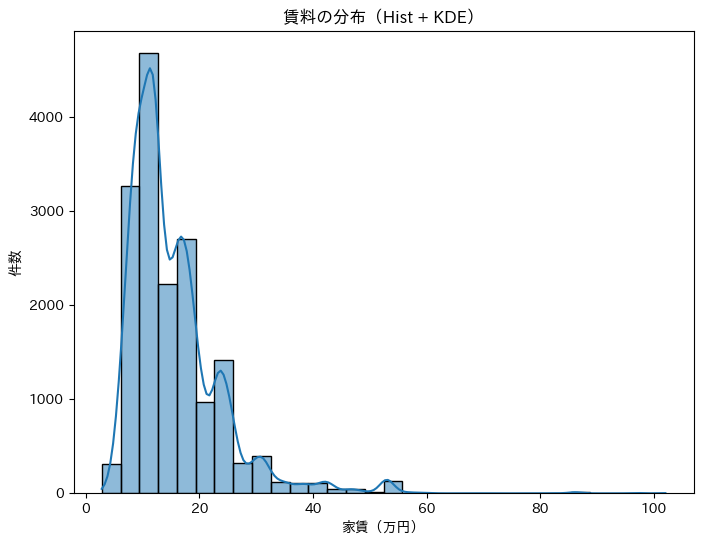

In [69]:
# In[6]:
plt.figure(figsize=(8,6))
sns.histplot(df['rent'], bins=30, kde=True)
plt.title("賃料の分布（Hist + KDE）")
plt.xlabel("家賃（万円）")
plt.ylabel("件数")
plt.show()

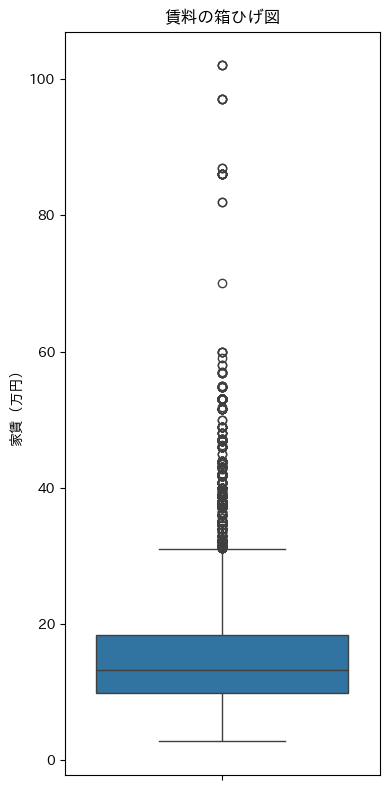

In [70]:
# In[7]:
plt.figure(figsize=(4,8))
sns.boxplot(y=df['rent'])
plt.title("賃料の箱ひげ図")
plt.ylabel("家賃（万円）")
plt.tight_layout()
plt.show()

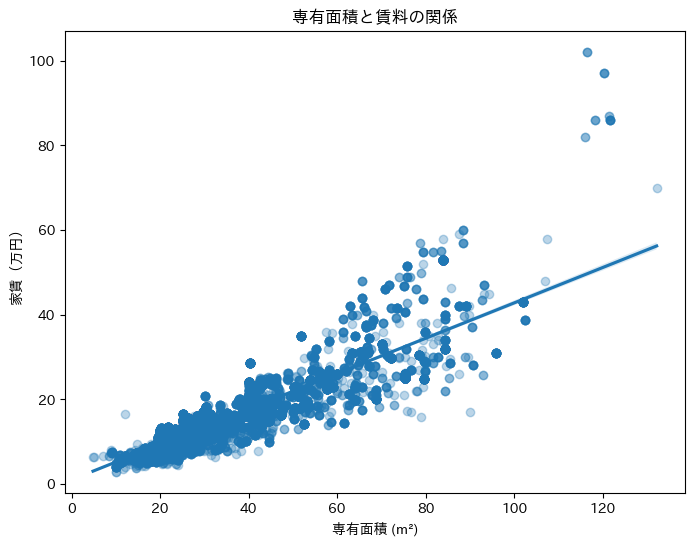

In [71]:
# In[8]:
plt.figure(figsize=(8,6))
sns.regplot(x='area_num', y='rent', data=df, scatter_kws={'alpha':0.3})
plt.title("専有面積と賃料の関係")
plt.xlabel("専有面積 (m²)")
plt.ylabel("家賃（万円）")
plt.show()

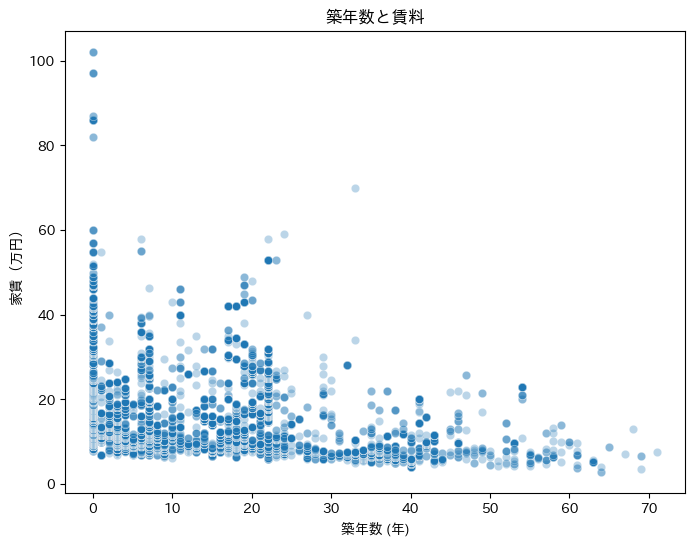

In [72]:
# In[9]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='age_num', y='rent', data=df, alpha=0.3)
plt.title("築年数と賃料")
plt.xlabel("築年数 (年)")
plt.ylabel("家賃（万円）")
plt.show()

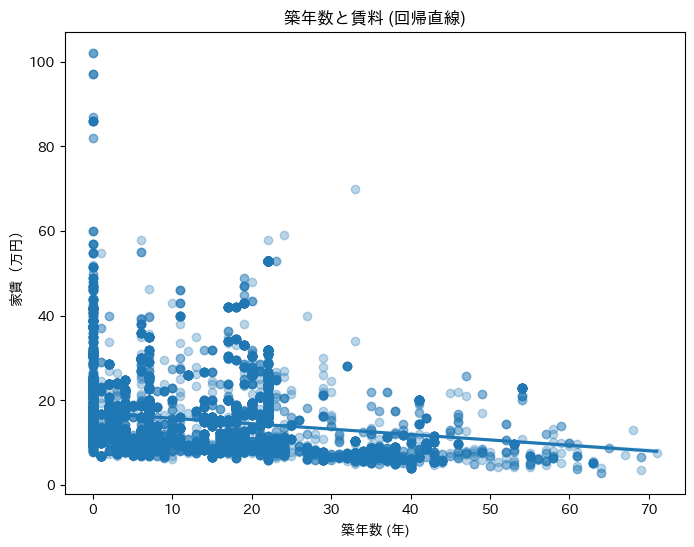

In [73]:
# In[10]:
plt.figure(figsize=(8,6))
sns.regplot(x='age_num', y='rent', data=df, scatter_kws={'alpha':0.3}, order=1)
plt.title("築年数と賃料 (回帰直線)")
plt.xlabel("築年数 (年)")
plt.ylabel("家賃（万円）")
plt.show()

In [74]:
# In[11]:
# 集計テーブルの作成
df_layout = df.groupby('layout').agg({
    'rent': 'mean',
    'area_num': 'mean',
    'management_fee_num': 'mean'
}).reset_index()
df_layout.rename(columns={'rent': 'mean_rent', 
                          'area_num': 'mean_area',
                          'management_fee_num': 'mean_mgmt_fee'}, inplace=True)
df_layout.sort_values(by='mean_rent', ascending=False, inplace=True)

df_layout

,layout,mean_rent,mean_area,mean_mgmt_fee
16,4LDK,59.000000,103.117273,24954.545455
17,4SLDK,44.787500,89.075000,12875.000000
14,3SLDK,31.962500,82.101250,7375.000000
13,3LDK,30.732332,77.288446,10982.253886
10,2SLDK,29.166071,72.156786,3232.142857
6,1SLDK,27.223810,62.696429,16702.380952
9,2LDK,26.474583,60.289762,13031.944444
12,3K,22.922222,41.535556,10000.000000
2,1LDK,19.515238,43.925773,10936.035334
3,1LK,18.500000,40.200000,20000.000000


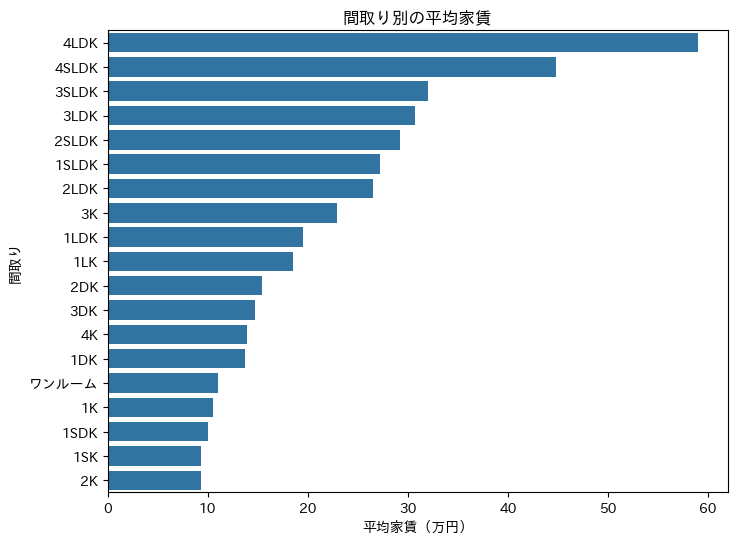

In [75]:
# In[12]:
plt.figure(figsize=(8,6))
sns.barplot(data=df_layout, x='mean_rent', y='layout')
plt.title("間取り別の平均家賃")
plt.xlabel("平均家賃（万円）")
plt.ylabel("間取り")
plt.show()

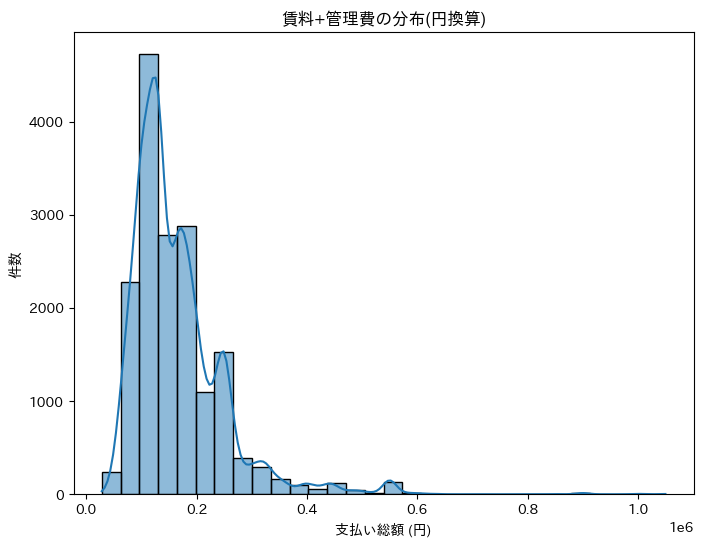

In [76]:
# In[13]:
# 家賃(万円)を円換算 -> rent * 10000円
# 管理費 + 賃料円合計 ->  (rent * 10000) + management_fee_num
df['total_monthly_cost'] = df['rent'] * 10000 + df['management_fee_num']

plt.figure(figsize=(8,6))
sns.histplot(df['total_monthly_cost'], bins=30, kde=True)
plt.title("賃料+管理費の分布(円換算)")
plt.xlabel("支払い総額 (円)")
plt.ylabel("件数")
plt.show()

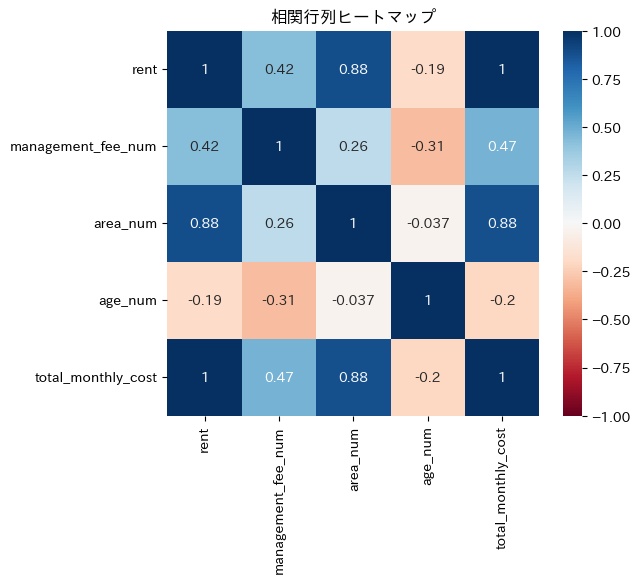

In [77]:
# In[14]:
corr_cols = ['rent','management_fee_num','area_num','age_num','total_monthly_cost']
corr_df = df[corr_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_df, annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title("相関行列ヒートマップ")
plt.show()

In [14]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import re

# DBからデータを取得するクラス
class SuumoDataLoader:
    def __init__(self, db_name="suumo_listings.db"):
        self.db_name = db_name
    
    def get_all_data(self) -> pd.DataFrame:
        """
        DBから全データを取得してDataFrameで返す
        """
        conn = sqlite3.connect(self.db_name)
        query = """
        SELECT 
            id, title, station, bus_walk, price, management_fee, 
            reikin_shikikin, area, layout, age 
        FROM listings
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
    
    def get_data_by_station(self, station_str: str) -> pd.DataFrame:
        """
        指定した駅名を含むデータを取得してDataFrameで返す。
        station列に対して部分一致検索を行う例。
        """
        conn = sqlite3.connect(self.db_name)
        query = f"""
        SELECT 
            id, title, station, bus_walk, price, management_fee, 
            reikin_shikikin, area, layout, age
        FROM listings
        WHERE station LIKE '%{station_str}%'
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

In [15]:
class SuumoDataProcessor:
    """
    取得したDataFrameの前処理を行い、解析のためのメソッドを提供するクラス。
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()  # 元データを複製
    
    def _parse_price(self, price_str: str) -> float:
        """
        '12.3万円'などの文字列を float に変換する補助メソッド。
        例:
         - '12.3万円' -> 12.3
         - '5万円' -> 5.0
         - '賃料情報なし'等 -> None
        """
        if not price_str or ("情報" in price_str):
            return None
        
        match = re.search(r"([\d\.]+)", price_str)
        if match:
            return float(match.group(1))
        return None
    
    def _parse_area(self, area_str: str) -> float:
        """
        '30m2'などの文字列から数値部分を float として取り出す。
        例:
         - '45.6m2' -> 45.6
         - '面積情報なし'等 -> None
        """
        if not area_str or ("情報" in area_str):
            return None
        
        match = re.search(r"([\d\.]+)", area_str)
        if match:
            return float(match.group(1))
        return None
    
    def clean_data(self) -> pd.DataFrame:
        """
        'price'列・'area'列の文字列を数値化した列を DataFrame に追加して返す。
        """
        # 賃料をfloat化して新しい列を作成
        self.df["price_numeric"] = self.df["price"].apply(self._parse_price)
        
        # 面積をfloat化して新しい列を作成
        self.df["area_numeric"] = self.df["area"].apply(self._parse_area)
        
        return self.df
    
    def show_basic_info(self):
        """
        データ概要表示用のメソッド。
        """
        print("===== データの先頭5行 =====")
        display(self.df.head())
        
        print("===== 欠損値の数 =====")
        print(self.df.isnull().sum())
        
        print("===== 基本統計量(数値カラムのみ) =====")
        display(self.df.describe())

In [16]:
# 分析対象の駅名リスト
stations_to_analyze = [
    "大井町",
    "品川シーサイド",
    "天王洲アイル",
    "東京テレポート",
    "国際展示場",
    "大森",
    "品川"
]

# データローダを初期化
loader = SuumoDataLoader(db_name="suumo_listings.db")

# 駅別DataFrameを保持する辞書
station_dfs = {}

for station_name in stations_to_analyze:
    df_station_raw = loader.get_data_by_station(station_name)
    processor = SuumoDataProcessor(df_station_raw)
    df_station_cleaned = processor.clean_data()  # price_numeric, area_numeric などが付与
    station_dfs[station_name] = df_station_cleaned

# 例: 大井町のデータを確認
print("大井町のデータ件数:", len(station_dfs["大井町"]))
display(station_dfs["大井町"].head())

大井町のデータ件数: 6853


,id,title,station,bus_walk,price,management_fee,reikin_shikikin,area,layout,age,price_numeric,area_numeric
0,5,6万円 ＪＲ京浜東北線/大井町,大井町,―徒歩14分,6万円,-,-/6万円,16.1m2,1K,築34年,6.0,16.10
1,8,6.3万円 ＪＲ京浜東北線/大井町,大井町,―徒歩6分,6.3万円,-,-/6.3万円,18.57m2,1K,築39年,6.3,18.57
2,12,6.6万円 ＪＲ京浜東北線/大井町,大井町,―徒歩5分,6.6万円,5000円,-/6.6万円,19.45m2,ワンルーム,築41年,6.6,19.45
3,13,6.6万円 ＪＲ京浜東北線/大井町,大井町,―徒歩5分,6.6万円,5000円,-/6.6万円,19.12m2,1K,築41年,6.6,19.12
4,14,6.7万円 ＪＲ京浜東北線/大井町,大井町,―徒歩12分,6.7万円,3000円,-/13.4万円,19.6m2,1K,築31年,6.7,19.60


In [17]:
comparison_data = []

for st_name, df_st in station_dfs.items():
    count_ = len(df_st)
    mean_price = df_st["price_numeric"].mean()
    median_price = df_st["price_numeric"].median()
    mean_area = df_st["area_numeric"].mean()
    
    comparison_data.append({
        "station": st_name,
        "count": count_,
        "mean_price(万円)": mean_price,
        "median_price(万円)": median_price,
        "mean_area(m2)": mean_area
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison

,station,count,mean_price(万円),median_price(万円),mean_area(m2)
0,大井町,6853,14.963387,15.000,34.769732
1,品川シーサイド,986,21.083773,19.300,54.826095
2,天王洲アイル,218,15.194037,10.700,35.485780
3,東京テレポート,5,43.000000,43.000,102.020000
4,国際展示場,6,29.166667,27.000,59.245000
5,大森,128,11.107812,9.725,28.256484
6,品川,3689,20.966460,18.200,44.401279


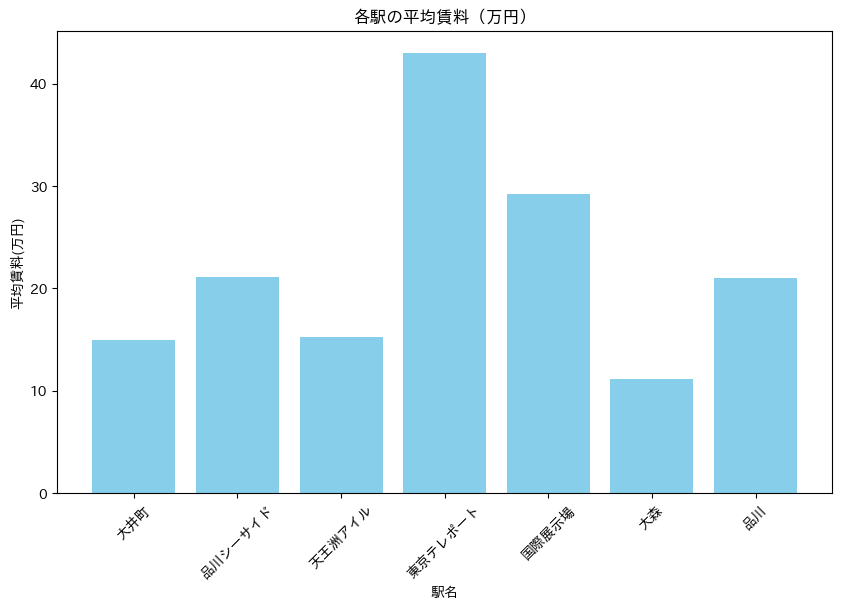

In [41]:
plt.figure(figsize=(10, 6))
plt.bar(df_comparison["station"], df_comparison["mean_price(万円)"], color="skyblue")
plt.title("各駅の平均賃料（万円）")
plt.xlabel("駅名")
plt.ylabel("平均賃料(万円)")
plt.xticks(rotation=45)
plt.show()

/var/folders/ty/6yshdyms5gq72_y217gspm8w0000gn/T/ipykernel_48348/1052297122.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=labels_for_box, showmeans=True)


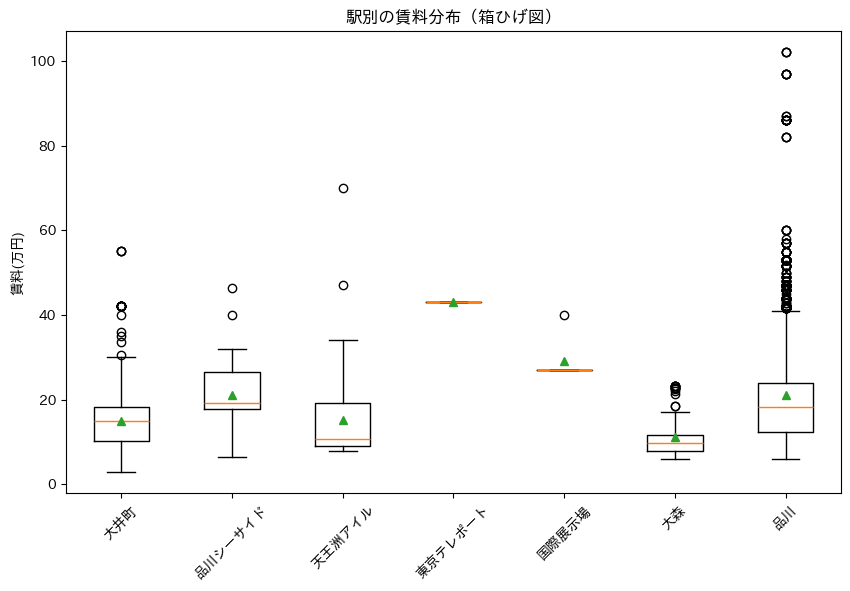

In [42]:
plt.figure(figsize=(10, 6))

data_for_box = []
labels_for_box = []

for st_name, df_st in station_dfs.items():
    rents = df_st["price_numeric"].dropna().tolist()
    if len(rents) > 0:
        data_for_box.append(rents)
        labels_for_box.append(st_name)

plt.boxplot(data_for_box, labels=labels_for_box, showmeans=True)
plt.title("駅別の賃料分布（箱ひげ図）")
plt.ylabel("賃料(万円)")
plt.xticks(rotation=45)
plt.show()

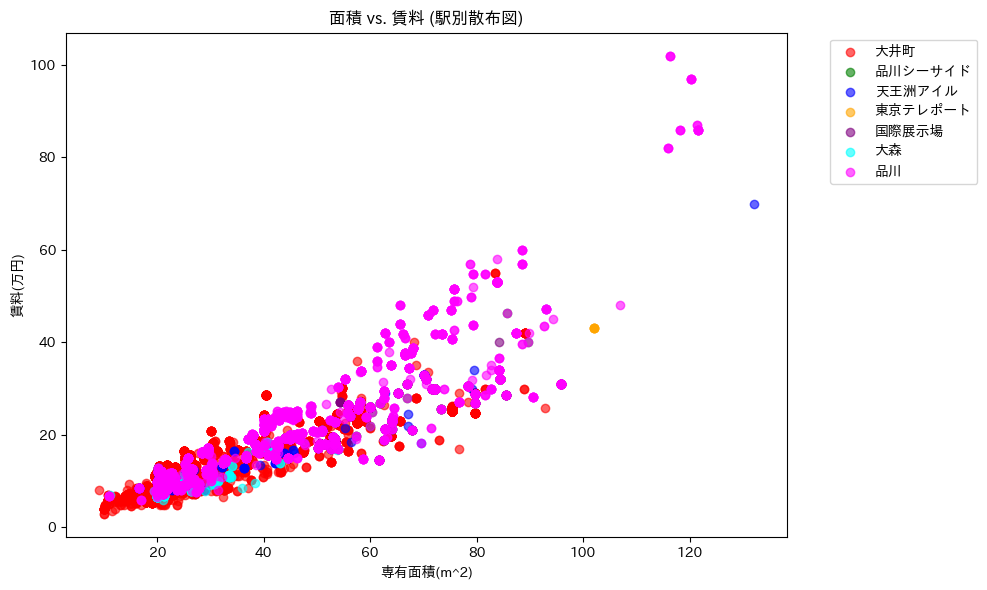

In [43]:
plt.figure(figsize=(10,6))
colors = ["red", "green", "blue", "orange", "purple", "cyan", "magenta"]

for i, (st_name, df_st) in enumerate(station_dfs.items()):
    plt.scatter(
        df_st["area_numeric"], 
        df_st["price_numeric"], 
        color=colors[i % len(colors)],
        alpha=0.6,
        label=st_name
    )

plt.title("面積 vs. 賃料 (駅別散布図)")
plt.xlabel("専有面積(m^2)")
plt.ylabel("賃料(万円)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # グラフ外に凡例を置く例
plt.tight_layout()
plt.show()

In [56]:
# In[1]

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlibで日本語表示用フォントを使う場合は環境に応じて設定してください
# import matplotlib_fontja  # すでに導入済みを想定 (質問文で触れられているため)

class SuumoDataLoader:
    """
    SUUMOのスクレイピングデータをDBから読み込み、
    Pandas DataFrameとして返すクラス
    """
    def __init__(self, db_name="suumo_listings.db"):
        self.db_name = db_name

    def load_data(self, station=None):
        """
        DBからデータを取得し、DataFrameとして返す。
        stationを指定した場合、駅名にstationを含む(部分一致)データのみ取得。
        """
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()
        
        # stationが指定されていればWHERE句でフィルタ
        if station:
            query = """
                SELECT title, station, bus_walk, price, 
                       management_fee, reikin_shikikin, area, layout, age
                FROM listings
                WHERE station LIKE ?
            """
            station_search = f"%{station}%"  # 部分一致
            cursor.execute(query, (station_search,))
        else:
            query = """
                SELECT title, station, bus_walk, price, 
                       management_fee, reikin_shikikin, area, layout, age
                FROM listings
            """
            cursor.execute(query)
        
        rows = cursor.fetchall()
        columns = [col[0] for col in cursor.description]
        conn.close()

        df = pd.DataFrame(rows, columns=columns)
        return df


# ここで定義したクラスや関数を使ってDBのデータをロードし、分析用DataFrameを作る準備をします。

print("SuumoDataLoaderクラスを定義しました。")

SuumoDataLoaderクラスを定義しました。


In [57]:
# In[2]

# インスタンス作成
loader = SuumoDataLoader("suumo_listings.db")

# station指定なしで全データ取得
df_all = loader.load_data()

# DBの中身を直接selectして件数確認 - 頭から5件ぐらい表示
print("=== 全データの件数 ===")
print(len(df_all))

print("\n=== データサンプル（先頭5件）===")
display(df_all.head(5))

print("\n=== カラム情報 ===")
display(df_all.info())

=== 全データの件数 ===
16899

=== データサンプル（先頭5件）===


,title,station,bus_walk,price,management_fee,reikin_shikikin,area,layout,age
0,5万円 ＪＲ京浜東北線/大井町,大井町,―徒歩12分,5万円,2000円,5万円/5万円,15m2,ワンルーム,築36年
1,5.8万円 ＪＲ京浜東北線/大井町,大井町,―徒歩14分,5.8万円,-,-/5.8万円,16.1m2,1K,築34年
2,5.8万円 ＪＲ京浜東北線/大井町,大井町,―徒歩14分,5.8万円,-,-/5.8万円,16.1m2,1K,築34年
3,5.8万円 ＪＲ京浜東北線/大井町,大井町,―徒歩14分,5.8万円,-,-/5.8万円,16.1m2,1K,築34年
4,6万円 ＪＲ京浜東北線/大森,大森,―徒歩10分,6万円,4000円,6万円/-,21m2,1K,築33年



=== カラム情報 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16899 entries, 0 to 16898
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            16899 non-null  object
 1   station          16899 non-null  object
 2   bus_walk         16899 non-null  object
 3   price            16899 non-null  object
 4   management_fee   16899 non-null  object
 5   reikin_shikikin  16899 non-null  object
 6   area             16899 non-null  object
 7   layout           16899 non-null  object
 8   age              16899 non-null  object
dtypes: object(9)
memory usage: 1.2+ MB


None

In [58]:
# In[3]

def preprocess_data(df):
    """
    取得したDataFrameに対し、
      - 賃料(万円単位)をfloat変換
      - 面積(㎡)をfloat変換
    などの前処理を行う。
    """
    df = df.copy()

    # 賃料の数字部分のみ抽出
    # 例: '10.2万円' -> 10.2, '12.8万円' -> 12.8
    def parse_rent(rent_str):
        # 文字列が空やNoneの場合はNaNにする
        if not rent_str or (rent_str.strip() == ""):
            return np.nan
        # 金額部だけ抜き出す
        rent_str = rent_str.replace("万円", "").replace(",", "").strip()
        # 数値変換
        try:
            return float(rent_str)
        except ValueError:
            return np.nan

    # 面積の数字部分のみ抽出
    # 例: '30m2' -> 30.0
    def parse_area(area_str):
        if not area_str or (area_str.strip() == ""):
            return np.nan
        area_str = area_str.replace("m2", "").replace("m²", "").replace("㎡", "").strip()
        # 数値変換
        try:
            return float(area_str)
        except ValueError:
            return np.nan

    # 賃料の変換
    df["price"] = df["price"].apply(parse_rent)
    # 面積の変換
    df["area"] = df["area"].apply(parse_area)

    return df

df_all_prep = preprocess_data(df_all)

print("=== 前処理後データの先頭5件 ===")
display(df_all_prep.head(5))

print("\n=== 数値変換後のカラム型情報 ===")
print(df_all_prep.dtypes)

=== 前処理後データの先頭5件 ===


,title,station,bus_walk,price,management_fee,reikin_shikikin,area,layout,age
0,5万円 ＪＲ京浜東北線/大井町,大井町,―徒歩12分,5.0,2000円,5万円/5万円,15.0,ワンルーム,築36年
1,5.8万円 ＪＲ京浜東北線/大井町,大井町,―徒歩14分,5.8,-,-/5.8万円,16.1,1K,築34年
2,5.8万円 ＪＲ京浜東北線/大井町,大井町,―徒歩14分,5.8,-,-/5.8万円,16.1,1K,築34年
3,5.8万円 ＪＲ京浜東北線/大井町,大井町,―徒歩14分,5.8,-,-/5.8万円,16.1,1K,築34年
4,6万円 ＪＲ京浜東北線/大森,大森,―徒歩10分,6.0,4000円,6万円/-,21.0,1K,築33年



=== 数値変換後のカラム型情報 ===
title               object
station             object
bus_walk            object
price              float64
management_fee      object
reikin_shikikin     object
area               float64
layout              object
age                 object
dtype: object


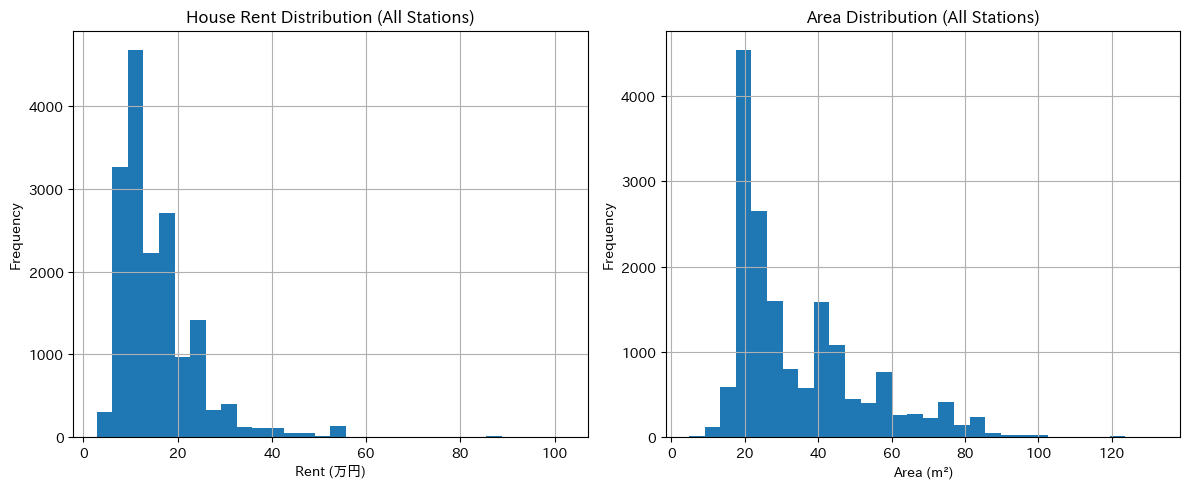

=== 家賃の基本統計量 ===


count    16899.000000
mean        15.565062
std          8.430821
min          2.800000
25%          9.900000
50%         13.200000
75%         18.400000
max        102.000000
Name: price, dtype: float64


=== 面積の基本統計量 ===


count    16899.000000
mean        34.754956
std         17.866143
min          4.830000
25%         21.000000
50%         26.590000
75%         43.680000
max        132.190000
Name: area, dtype: float64

In [59]:
# In[4]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 家賃のヒストグラム
df_all_prep['price'].dropna().hist(bins=30, ax=axes[0])
axes[0].set_title("House Rent Distribution (All Stations)")
axes[0].set_xlabel("Rent (万円)")
axes[0].set_ylabel("Frequency")

# 面積のヒストグラム
df_all_prep['area'].dropna().hist(bins=30, ax=axes[1])
axes[1].set_title("Area Distribution (All Stations)")
axes[1].set_xlabel("Area (m²)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

print("=== 家賃の基本統計量 ===")
display(df_all_prep['price'].describe())

print("\n=== 面積の基本統計量 ===")
display(df_all_prep['area'].describe())

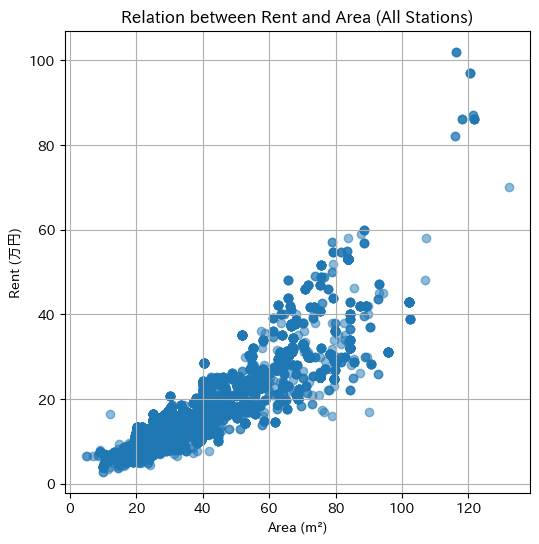

In [60]:
# In[5]

plt.figure(figsize=(6, 6))
plt.scatter(df_all_prep['area'], df_all_prep['price'], alpha=0.5)
plt.title("Relation between Rent and Area (All Stations)")
plt.xlabel("Area (m²)")
plt.ylabel("Rent (万円)")
plt.grid(True)
plt.show()

- 新馬場, 品川, 大森, 大井町, 立会川, 西大井, 鮫洲, 青物横丁, 下神明, 北品川, 大崎, 大井競馬場前,
  大森海岸, 天王洲アイル, 品川シーサイド, 有明テニスの森, 有明, お台場海浜公園, 戸越公園,
  尾山台, 高輪ゲートウェイ, 東雲, 西小山, 戸越, 国際展示場, 東京テレポート, 新豊洲

In [61]:
# In[6]

stations = [
    "新馬場", "品川", "大森", "大井町", "立会川", "西大井", "鮫洲", "青物横丁", 
    "下神明", "北品川", "大崎", "大井競馬場前", "大森海岸", "天王洲アイル",
    "品川シーサイド", "有明テニスの森", "有明", "お台場海浜公園", "戸越公園",
    "尾山台", "高輪ゲートウェイ", "東雲", "西小山", "戸越", "国際展示場",
    "東京テレポート", "新豊洲"
]

loader = SuumoDataLoader("suumo_listings.db")

# 駅ごとのDataFrameを格納する辞書
station_dfs = {}
for st in stations:
    df_st = loader.load_data(station=st)
    df_st_prep = preprocess_data(df_st)
    # 何件かは確認
    station_dfs[st] = df_st_prep
    print(f"{st} 駅: {len(df_st_prep)} 件")

新馬場 駅: 1970 件
品川 駅: 3704 件
大森 駅: 134 件
大井町 駅: 6609 件
立会川 駅: 923 件
西大井 駅: 1203 件
鮫洲 駅: 437 件
青物横丁 駅: 576 件
下神明 駅: 429 件
北品川 駅: 618 件
大崎 駅: 399 件
大井競馬場前 駅: 49 件
大森海岸 駅: 23 件
天王洲アイル 駅: 224 件
品川シーサイド 駅: 965 件
有明テニスの森 駅: 114 件
有明 駅: 161 件
お台場海浜公園 駅: 44 件
戸越公園 駅: 9 件
尾山台 駅: 2 件
高輪ゲートウェイ 駅: 5 件
東雲 駅: 1 件
西小山 駅: 1 件
戸越 駅: 11 件
国際展示場 駅: 6 件
東京テレポート 駅: 5 件
新豊洲 駅: 4 件


/var/folders/ty/6yshdyms5gq72_y217gspm8w0000gn/T/ipykernel_48348/1779740054.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(rent_data, labels=stations_for_plot, vert=True, showfliers=True)


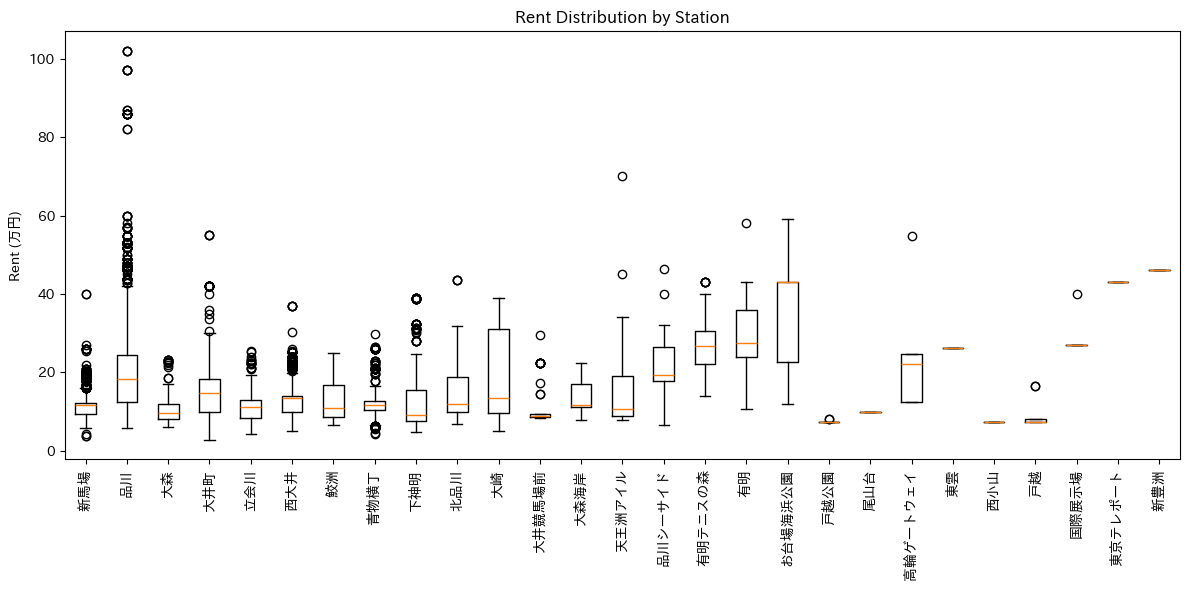

In [62]:
# In[7]

# 駅ごとの家賃のリストを作成
stations_for_plot = []
rent_data = []

for st in stations:
    df_st = station_dfs[st]
    # 件数が0の場合は除外
    if len(df_st) > 0:
        # 駅名
        stations_for_plot.append(st)
        # 家賃の配列
        rent_data.append(df_st['price'].dropna())

plt.figure(figsize=(12, 6))
plt.boxplot(rent_data, labels=stations_for_plot, vert=True, showfliers=True)
plt.xticks(rotation=90)  # 駅名が見切れないように回転
plt.title("Rent Distribution by Station")
plt.ylabel("Rent (万円)")
plt.tight_layout()
plt.show()

,Station,MeanRent,MedianRent,Count
22,西小山,7.300000,7.30,1
18,戸越公園,7.577778,7.40,9
23,戸越,9.200000,7.40,11
19,尾山台,9.800000,9.80,2
2,大森,11.089179,9.65,134
4,立会川,11.143954,11.20,923
0,新馬場,11.741117,11.80,1970
11,大井競馬場前,11.742857,8.90,49
7,青物横丁,12.406424,11.60,576
6,鮫洲,12.508581,11.00,437


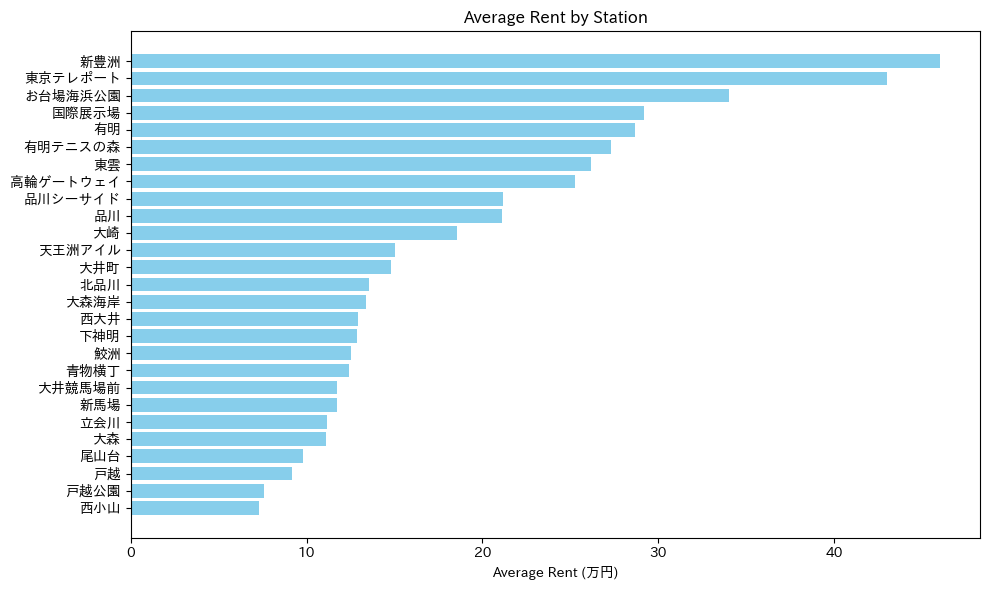

In [63]:
# In[8]

station_avg = []
station_median = []
station_count = []

for st in stations_for_plot:  # 上記の箱ひげ図作成時に得た駅リストと同じ順
    df_st = station_dfs[st]
    avg_price = df_st['price'].mean()
    median_price = df_st['price'].median()
    count_data = len(df_st.dropna(subset=['price']))
    station_avg.append(avg_price)
    station_median.append(median_price)
    station_count.append(count_data)

df_station_stats = pd.DataFrame({
    'Station': stations_for_plot,
    'MeanRent': station_avg,
    'MedianRent': station_median,
    'Count': station_count
}).sort_values(by='MeanRent')

display(df_station_stats)

# 平均家賃が低い順に並べて棒グラフ
plt.figure(figsize=(10, 6))
plt.barh(df_station_stats['Station'], df_station_stats['MeanRent'], color='skyblue')
plt.xlabel("Average Rent (万円)")
plt.title("Average Rent by Station")
plt.tight_layout()
plt.show()

# 中央値でも同様に可視化可能